# Detect Your Own Skeleton
In this user-friendly notebook, you can upload your own image and use our model trained from scratch to detect your skeleton.<br>
## Input here
Please input the path to your image and the model in the following block:

In [1]:
img_path = 'util_data/playing.jpg'
model_path = 'weights/final_model.pth'

Then, just run the following blocks to the end, and you will visualize the PAF and Heatmap outputs as well as the detected skeletons.

In [2]:
!pip install munkres
from munkres import Munkres, make_cost_matrix
import torch
import torchvision
import torch.nn as nn
from PIL import Image
from collections import defaultdict
from PIL import ImageOps
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import math
import numpy as np
import json
import copy
from torchvision.models import vgg19
import cv2
import torch.nn.functional as Func
from skimage.feature import peak_local_max
import warnings
warnings.filterwarnings("ignore")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#### Limbs to be detected
Here are the limbs to be detected. If you want to ignore some limbs among them, refer to dictionary `idx_to_keypoint_type` and delete the pairs in both `part_pairs` and `INFERENCE_SKELETON`.

In [3]:
idx_to_keypoint_type = {0: 'nose', 1: 'left_eye', 2: 'right_eye', 3: 'left_ear', 4: 'right_ear', 5: 'left_shoulder', 6: 'right_shoulder', 7: 'left_elbow', 8: 'right_elbow', 9: 'left_wrist', 10: 'right_wrist', 11: 'left_hip', 12: 'right_hip', 13: 'left_knee', 14: 'right_knee', 15: 'left_ankle', 16: 'right_ankle'}

part_pairs = [['left_ankle', 'left_knee'], ['left_knee', 'left_hip'], ['right_ankle', 'right_knee'], ['right_knee', 'right_hip'], ['left_hip', 'right_hip'], ['left_shoulder', 'left_hip'], ['right_shoulder', 'right_hip'], ['left_shoulder', 'right_shoulder'], ['left_shoulder', 'left_elbow'], ['right_shoulder', 'right_elbow'], ['left_elbow', 'left_wrist'], ['right_elbow', 'right_wrist'], ['left_eye', 'right_eye'], ['nose', 'left_eye'], ['nose', 'right_eye'], ['left_eye', 'left_ear'], ['right_eye', 'right_ear'], ['left_ear', 'left_shoulder'], ['right_ear', 'right_shoulder'], ['left_shoulder', 'left_wrist'], ['right_shoulder', 'right_wrist'], ['left_hip', 'left_ankle'], ['right_hip', 'right_ankle']]

INFERENCE_SKELETON = np.array([[15, 13], [13, 11], [16, 14], [14, 12], [11, 12], [5, 11], [6, 12], [5, 6], [5, 7], [6, 8], [7, 9], [8, 10], [1, 2], [0, 1], [0, 2], [1, 3], [2, 4], [3, 5], [4, 6]])

#### Transform
Here are the functions used to transform your image into two images, one is of size $368 \times 368$ and the other is of size $46 \times 46$.

In [4]:
class ResizeImg(object):
    def __init__(self, size=368):
        self.size = size
        self.paf_sz = int(size*46/368)
        self.Resize = transforms.Resize((self.paf_sz, self.paf_sz))
    
    def __call__(self, image):
        IM_H, IM_W = image.height, image.width
        if(IM_H > IM_W):
            w = int(self.size*IM_W/IM_H)
            h = self.size
            pad_val = int((self.size-w)/2)
            pad = (self.size-w-pad_val,0,pad_val ,0)
        
        else:
            h = int(self.size*IM_H/IM_W)
            w = self.size
            pad_val = int((self.size-h)/2)
            pad = (0,self.size-h-pad_val,0,pad_val)
        
        resized_img = ImageOps.expand(image.resize((w,h),resample=Image.BILINEAR), pad)
        return resized_img , self.Resize(resized_img)

class Resize(object):
    def __init__(self, size=368):
        self.size = size
    
    def __call__(self, im):
        im = Image.fromarray(im)
        if(im.height > im.width):
            w = int(self.size*im.width/im.height)
            h = self.size
            pad_val = int((self.size-w)/2)
            pad = (self.size-w-pad_val,0,pad_val,0)
        else:
            h = int(self.size*im.height/im.width)
            w = self.size
            pad_val = int((self.size-h)/2)
            pad = (0,self.size-h-pad_val,0,pad_val)
        return ImageOps.expand(im.resize((w,h),resample=Image.BILINEAR), pad)

#### Model
Here is our model with 10658963 parameters, which contains 4 PAF stages and 2 Heatmap stages. For more information, please refer to the PDF that introduces our training process.

In [5]:
class F(nn.Module):
    def __init__(self):
        super(F, self).__init__()
        self.vgg = vgg19(pretrained=False).features[:23]
        self.conv_4_3_and_4_4 = nn.Sequential(
                                              nn.Conv2d(512, 256, 3, 1, 1),
                                              nn.BatchNorm2d(256),
                                              nn.ReLU(inplace=True),
                                              nn.Conv2d(256, 125, 3, 1, 1),
                                              nn.BatchNorm2d(125),
                                              nn.ReLU(inplace=True)
                                              )
        
        for param in self.vgg.parameters():
            param.requires_grad = False
        
    
    def forward(self, x):
        return self.conv_4_3_and_4_4(self.vgg(x))

In [6]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels=128):
        #64, 32, 32
        super(Conv_Block, self).__init__()
        self.C1 = nn.Sequential(
                                nn.Conv2d(in_channels, 64, 3, 1, 1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True)
                                )
        self.C2 = nn.Sequential(
                                nn.Conv2d(64, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True)
                                )
        self.C3 = nn.Sequential(
                                nn.Conv2d(32, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True)
                                )

    def forward(self, x):
        c1_out = self.C1(x)
        c2_out = self.C2(c1_out)
        c3_out = self.C3(c2_out)
        return torch.cat((c1_out, c2_out, c3_out), dim=1)

In [7]:
def get_stage_block(in_channels, out_channels):
    return nn.Sequential(
                         Conv_Block(in_channels),
                         Conv_Block(128),
                         Conv_Block(128),
                         Conv_Block(128),
                         Conv_Block(128),
                         nn.Conv2d(128,128,1,1,0),
                         nn.BatchNorm2d(128),
                         nn.ReLU(inplace=True),
                         nn.Conv2d(128,out_channels,1,1,0)
                         )

In [8]:
class PAF_Stages(nn.Module):
    # 46 = 39+8 ?
    def __init__(self, in_channels=128, paf_out_channels=38+8):
        super(PAF_Stages, self).__init__()
        self.Stage1 = get_stage_block(in_channels, paf_out_channels)
        self.Stage2 = get_stage_block(in_channels+paf_out_channels, paf_out_channels)
        self.Stage3 = get_stage_block(in_channels+paf_out_channels, paf_out_channels)
        self.Stage4 = get_stage_block(in_channels+paf_out_channels, paf_out_channels)

    def forward(self, img_stg_input, F):
        res = []
        o1 = self.Stage1(torch.cat((img_stg_input.clone(), F.clone()), dim=1))
        res.append(o1)
        o2 = self.Stage2(torch.cat((img_stg_input.clone(), F.clone(), o1), dim=1))
        res.append(o2)
        o3 = self.Stage3(torch.cat((img_stg_input.clone(), F.clone(), o2), dim=1))
        res.append(o3)
        o4 = self.Stage4(torch.cat((img_stg_input.clone(), F.clone(), o3), dim=1))
        res.append(o4)
        return res
    

class Heatmap_Stages(nn.Module):
    def __init__(self, in_channels=128+38+8, hm_out_channels=18):
        super(Heatmap_Stages, self).__init__()
        self.Stage1 = get_stage_block(in_channels, hm_out_channels)
        self.Stage2 = get_stage_block(in_channels+hm_out_channels, hm_out_channels)
    
    def forward(self, img_stg_input, F, L):
        res = []
        o1 = self.Stage1(torch.cat((img_stg_input.clone(), F.clone(), L.clone()), dim=1))
        res.append(o1)
        o2 = self.Stage2(torch.cat((img_stg_input.clone(), F.clone(), L.clone(), o1), dim=1))
        res.append(o2)
        return res
    

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.F = F()
        self.PAF_Stages = PAF_Stages()
        self.Heatmap_Stages = Heatmap_Stages()
    
    def forward(self, img, img_stg_input):
        image_features = self.F(img)
        pafs_op = self.PAF_Stages(img_stg_input, image_features)
        heatmaps_op = self.Heatmap_Stages(img_stg_input, image_features, pafs_op[3])
        return pafs_op, heatmaps_op

#### Functions for inference and plotting
Here are our functions for inference and plotting, and their usage is summarized as:<br>

| Function Name | Goal | Input | Output |
| :----- | :---- | :---- | :---- |
| Plot_pafs | plot PAF outputs in 23+1 images | 368 image, predicted pafs, pairs to detect | None |
| Plot_heatmaps | plot PAF outputs in 18 images | 368 image, predicted masks | None |
| get_joint_positions | get all the detected joints | heatmaps, window size for NMS | a dictionary of detected all types of keypoints |
| get_peaks | find peaks in a single heatmap | one heatmap, window size for NMS | an array |
| calculate_affinity_score | calculate paf score between two detected keypoints | $j_1$, $j_2$, predicted paf, limb_width | a float |
| calculate_affinity_scores | calculate paf scores between two type of keypoints | a list of $j_1$, a list of $j_2$, predicted pafs, limb_width | an array of size $m \times n$ |
| compute_matches | compute matches between two type of keypoints | array of affinity scores, list of $j_1$, list of $j_1$ | a list of tuples |
| calculate_part_matches | compute matches of all type of keypoints | all the detected joints, predicted pafs | a dictionary |
| draw_bodypose | draw skeletons on an image | 368 image, matched limbs | cv2 image |

In [9]:
def plot_pafs(img, pafs, joint_pairs=part_pairs, figsize=(16,12)):
    fig, axes = plt.subplots(5, 5, figsize=figsize)
    x,y = img.shape[0]/30, img.shape[1]/30
    # store paf of each limb
    final = np.zeros((img.shape[0],img.shape[1]))
    
    for i,ax in enumerate(axes.flat):
        ax.axis('off')
        if(i<len(joint_pairs)):
            ax.text(x,y, joint_pairs[i][0]+'->'+joint_pairs[i][1], va='top', color="white", fontsize=12)
            ax.imshow(img)
            mask = np.logical_or(pafs[2*i], pafs[(2*i) + 1]).numpy().astype(int)
            final += mask
            ax.imshow(mask, 'jet', interpolation='none', alpha=0.7)
    ax.text(x,y, 'show all', va='top', color="white", fontsize=12)
    ax.imshow(img)
    ax.imshow((final>0), 'jet', interpolation='none', alpha=0.7)
    plt.tight_layout()

In [10]:
def get_peaks(part_heatmap, nms_window):
    pad = nms_window + 5
    padded_hm = np.pad(part_heatmap, pad_width=[(pad,pad),(pad,pad)], mode='constant', constant_values=0)
    # find the local max using a nonmaximum supression window
    coords = peak_local_max(padded_hm, min_distance=nms_window)
    
    # only detect 30 peaks at most
    if(len(coords)>30):
        thresh = 1e-1
        while(len(coords)>30):
            thresh = thresh + 0.1
            padded_hm[padded_hm<thresh] = 0
            coords = peak_local_max(padded_hm, min_distance=nms_window)
            
    if(len(coords)):
        coords[:,[0, 1]] = coords[:,[1, 0]]
        coords = coords-pad
    return coords.astype(float)


def plot_heatmaps(img, masks, idx_to_keypoint_type=idx_to_keypoint_type, figsize=(16,12)):
    fig, axes = plt.subplots(5, 4, figsize=figsize)
    
    for i,ax in enumerate(axes.flat):
        ax.axis('off')
        if(i<17):
            ax.imshow(img)
            # find peaks of a type of keypoint
            peaks = get_peaks(masks[i], nms_window=30)
            ax.text(10,10, idx_to_keypoint_type[i], va='top', color='white', fontsize=12)
            ax.imshow(masks[i], 'jet', interpolation='none', alpha=0.5)
            ax.plot(peaks[:,0], peaks[:,1], 'w+')
        if(i==17):
            ax.text(10,10, 'background', va='top', color='white', fontsize=12)
            ax.imshow(img)
            ax.imshow(masks[i], 'jet', interpolation='none', alpha=0.5)

    plt.tight_layout()

In [11]:
def calculate_affinity_score(j1, j2, paf_map, limb_width):
    score = 0
    mask = np.zeros((368, 368))               
    col, row = np.ogrid[:368, :368]
    
    limb_length = np.linalg.norm(j2 - j1)
    if(limb_length>1e-8):
        # calculate paf score between two detected keypoints
        v = (j2 - j1)/limb_length
        v_perp = np.array([v[1], -v[0]])
        center_point = (j1 + j2)/2
        cond1 = np.abs(np.dot(v, np.array([col, row]) - center_point))<= limb_length/2
        cond2 = np.abs(np.dot(v_perp, np.array([col, row]) - j1))<=limb_width
        
        mask = np.logical_and(cond1, cond2).transpose()
        x_s, y_s = np.logical_and(paf_map[0], mask), np.logical_and(paf_map[1], mask)
        non_zero_paf_pixels = np.logical_or(x_s, y_s).sum()
        res = np.tensordot(v, np.array([x_s, y_s]), axes=([0], [0])).sum()
        score = (res/mask.sum())*(non_zero_paf_pixels/mask.sum())**2
        
    return np.abs(score)


def calculate_affinity_scores(j1_list, j2_list, paf_map):
    affinity_scores = np.zeros((len(j1_list), len(j2_list)))
    j1_list_copy = j1_list.copy().astype(float)
    j2_list_copy = j2_list.copy().astype(float)
    
    # calculate paf scores between two type of keypoints
    for i, j1_pt in enumerate(j1_list):
        for j, j2_pt in enumerate(j2_list):
            affinity_scores[i,j] = calculate_affinity_score(j1_pt, j2_pt, paf_map, limb_width=5)
            
    return affinity_scores

In [12]:
def compute_matches(affinity_scores, j1_pts, j2_pts):
    matching_results = []
    j1_count, j2_count = affinity_scores.shape
    # use Hungarian algorithm to obtain optimal matching
    indices = Munkres().compute(make_cost_matrix(affinity_scores.tolist(), inversion_function=lambda x : 2 - x))
    
    for row,col in indices:
        if(affinity_scores[row,col]>0.1):
            matching_results.append((j1_pts[row], j2_pts[col], affinity_scores[row,col]))
            
    return matching_results


def calculate_part_matches(pred_joints_map, pred_pafs):
    matched_parts_map = defaultdict(lambda:[])
    # compute matches of all type of keypoints
    for i, part_pair in enumerate(INFERENCE_SKELETON):
        j1_id, j2_id = part_pair
        j1_list = pred_joints_map[j1_id]
        j2_list = pred_joints_map[j2_id]
        affinity_scores = []

        if(len(j1_list) and len(j2_list)):        
            affinity_scores = calculate_affinity_scores(j1_list, j2_list, pred_pafs[(2*i):(2*i)+2].numpy())

        if(len(affinity_scores)):
            matched_parts_map[(j1_id, j2_id)] = compute_matches(affinity_scores, pred_joints_map[j1_id], pred_joints_map[j2_id])

    return matched_parts_map

In [13]:
def get_joint_positions(hms, nms_window):
    joint_pos_map = {}
    # for each type of keypoint, get the peaks
    for i, hm in enumerate(hms.numpy()):
        joint_pos_map[i] = get_peaks(hm, nms_window) 
    return joint_pos_map

In [14]:
def draw_bodypose(canvas, part_matches_map):
    H, W = canvas.shape[:2]
    # adjust width of the plotting
    stickwidth = 2
    if W>1000:
        stickwidth = 12
    elif(W>640):
        stickwidth = 8
    
    font = cv2.FONT_HERSHEY_SIMPLEX 
    colors = [[255,0,0], [255,0,0], [255,0,0], 
              [255, 170,0], [255, 170,0], 
              [0, 255,0], [0, 255,0], 
              [0, 255,255], [0, 255,255],
              [0, 170,255], [0, 170,255],
              [0,0,255], [0,0,255],
              [255,0,170], [255,0,170],
              [170,0,255], [170,0,255]]
  
    for j1, j2 in part_matches_map:
        if(len(part_matches_map[(j1, j2)])):
            
            for pt1, pt2, part_conf in part_matches_map[(j1, j2)]:
                pt1_cpy = pt1.copy()
                pt2_cpy = pt2.copy()
                cv2.circle(canvas, (int(pt1_cpy[0]), int(pt1_cpy[1])), stickwidth, colors[j1], thickness=-1)
                cv2.circle(canvas, (int(pt2_cpy[0]), int(pt2_cpy[1])), stickwidth, colors[j2], thickness=-1)

                cur_canvas = canvas.copy()
                # calculate the shape to draw
                X = [pt1_cpy[1], pt2_cpy[1]]
                Y = [pt1_cpy[0], pt2_cpy[0]]
                mX = np.mean(X)
                mY = np.mean(Y)
                length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
                angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
                polygon = cv2.ellipse2Poly((int(mY), int(mX)), (int(length / 2), stickwidth), int(angle), 0, 360, 1)
                cv2.fillConvexPoly(cur_canvas, polygon, colors[j1])

                canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
                
    return canvas

## Visualize results

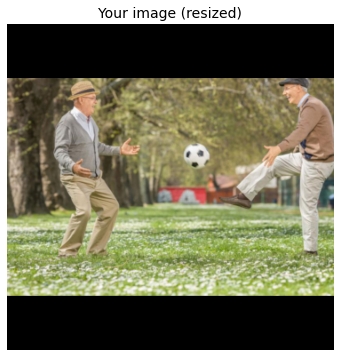

In [15]:
# load the model
model = Net().to(device)
model.load_state_dict(torch.load(model_path))

# pre-process your image
img = Image.open(img_path)
img, img_stg_input = ResizeImg(size=368)(img)
mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225])
img,img_stg_input = transforms.ToTensor()(img),transforms.ToTensor()(img_stg_input)
img = transforms.Normalize(mean, std)(img)

with torch.no_grad():
    model.eval()
    pred_paf_stages, pred_hm_stages = model(img.unsqueeze(0).to(device), img_stg_input.unsqueeze(0).to(device))
    paf_pred = Func.interpolate(pred_paf_stages[-1].clone().detach(), 368, mode='bilinear', align_corners=True)[0].cpu()
    hm_pred = Func.interpolate(pred_hm_stages[-1].clone().detach(), 368, mode='bilinear', align_corners=True)[0].cpu()
    
paf_pred[torch.abs(paf_pred)<1e-1] = 0
hm_pred[torch.abs(hm_pred)<3e-1] = 0

# have a look at your resized image
un_img = img.mul(std[:,np.newaxis,np.newaxis]).add(mean[:,np.newaxis,np.newaxis])
plt.figure(figsize=(6,6))
plt.imshow(transforms.ToPILImage()(un_img));
plt.axis('off')
plt.title('Your image (resized)',size=14);

### PAF outputs
size: $23 \times 46 \times 46$, where<br>
$23$ denotes `number of pairs`, and $ 46 \times 46 $ denotes `size of each PAF mask`

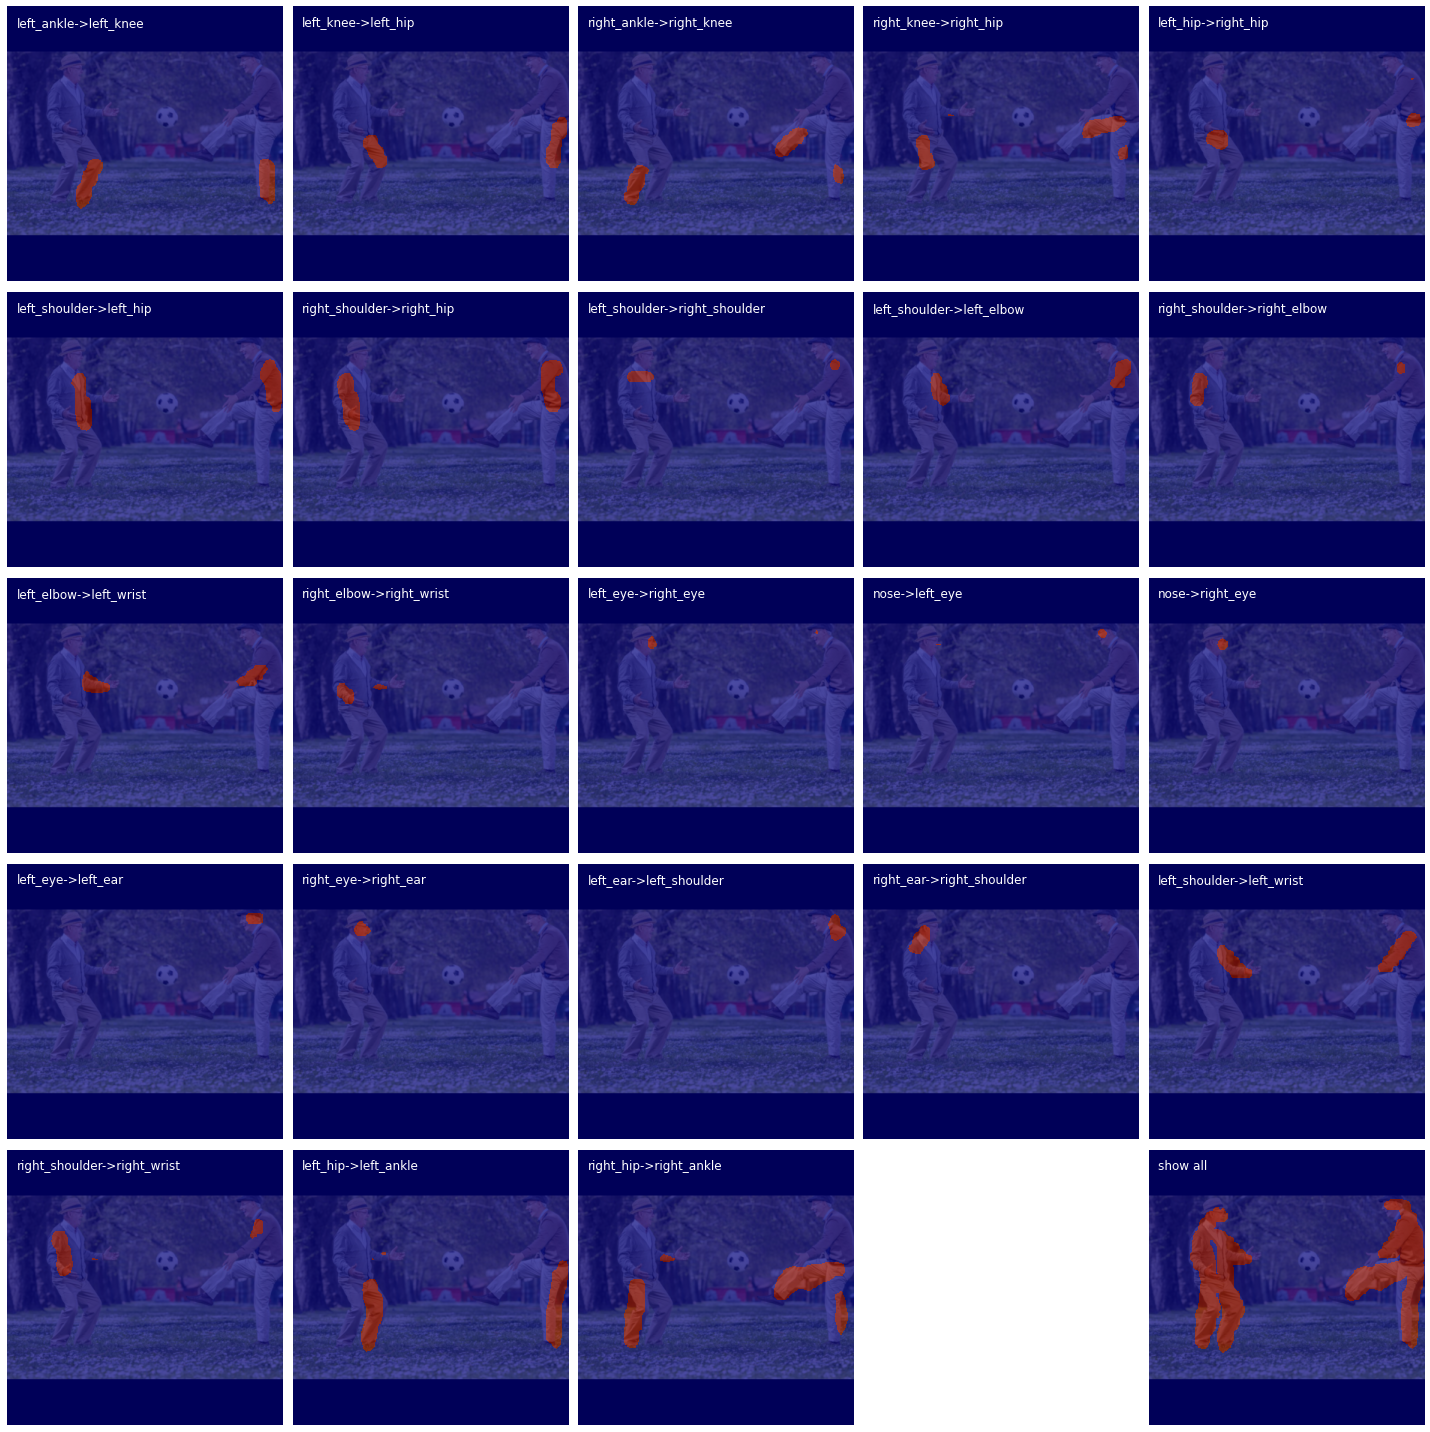

In [16]:
un_img = un_img.numpy().transpose(1,2,0)
plot_pafs(un_img, paf_pred, figsize=(20,20))

### Heatmap outputs
size: $18 \times 46 \times 46$, where<br>
$18 =$ number of keypoints $(17)$ + background $(1)$, and $ 46 \times 46 $ denotes `size of each Heatmap mask`

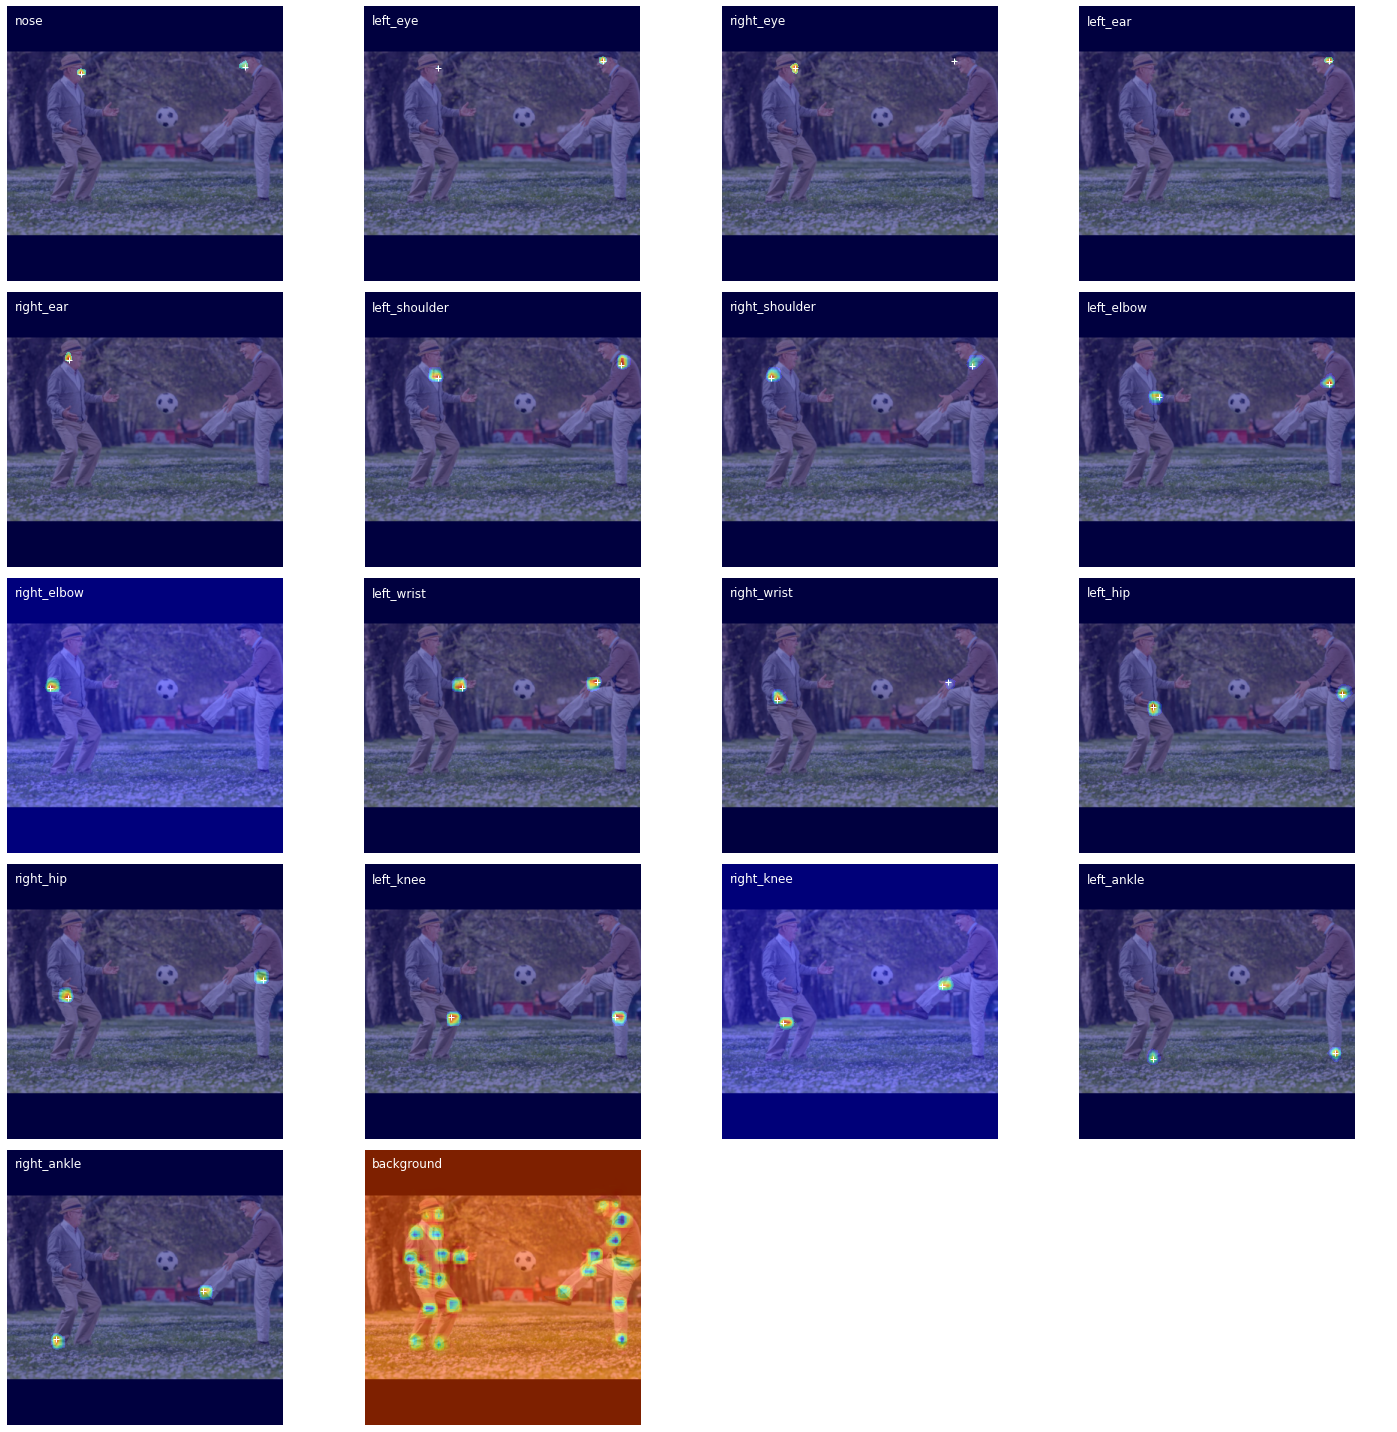

In [17]:
plot_heatmaps(un_img, hm_pred, figsize=(20,20))

### Skeletons

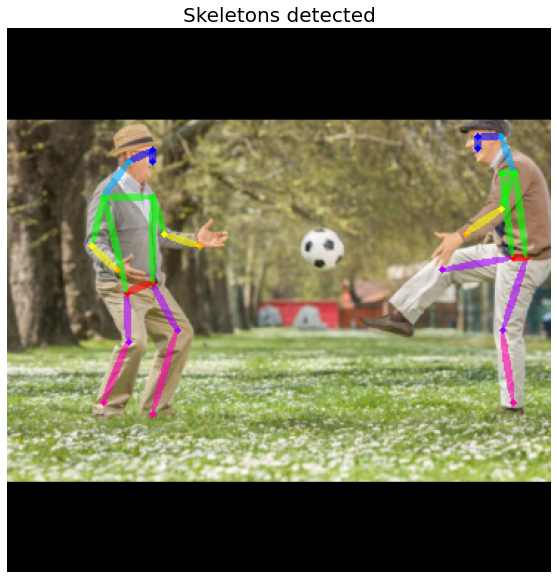

In [18]:
joint_pos_map = get_joint_positions(hm_pred, nms_window=30)
part_matches_map = calculate_part_matches(joint_pos_map, paf_pred)

oriImg = cv2.imread(img_path)
canvas = draw_bodypose(np.array(Resize()(oriImg)), part_matches_map)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(canvas[:, :, [2, 1, 0]])
plt.title('Skeletons detected',size=20);